In [2]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 10)

import matplotlib.pyplot as plt
import psycopg2
import numpy as np
import sklearn
import requests
import scipy

Populating the interactive namespace from numpy and matplotlib


In [3]:
conn = psycopg2.connect(database="delay", user="nikita")
conn.autocommit = True

In [4]:
line, way = 95, 2

cur = conn.cursor()
cur.execute("SELECT * FROM traject WHERE line='%i' AND way=%i ORDER BY id;" % (line, way))
data = cur.fetchall()

In [5]:
from collections import namedtuple
Traject = namedtuple("Traject", ('id', 'line', 'way', 'timestamps', 'start'))
models = [Traject(*row) for row in data]

In [6]:
stib_stops = requests.get("https://stib-mivb-api.herokuapp.com/network/line/%s/%s" % (line, way)).json()['stops']
len_stops = len(max(models, key=lambda x: len(x.timestamps)).timestamps)
assert len(stib_stops) == len_stops

In [7]:
vectors = []
for model in models:
    vector = [np.nan] * (len_stops - 1)
    
    for i in range(len_stops - 1):
        try:
            vector[i] = (model.timestamps[i + 1] - model.timestamps[i]).total_seconds()
        except (IndexError, TypeError):
            vector[i] = np.nan
    vectors.append(vector)

vectors = np.array(vectors)

In [17]:
from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values="NaN", strategy='mean', axis=0)
imputed_vectors = imputer.fit_transform(vectors)

# Split the vectors in 2: features are v[:12] and targets are v[12:]
X, Y = imputed_vectors[:,:12], imputed_vectors[:,12:]

# Lower the weight of old stops
def lower_weight(row):
    weights = 1/ np.arange(X.shape[1], 0, -1)
    return row * weights
X = np.apply_along_axis(lower_weight, 1, X)

from sklearn.cross_validation import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [18]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=130, n_jobs=-1).fit(X_train, Y_train)
predictions = knn.predict(X_test)

# Score d'une prédiction
Il y a plusieurs méthodes pour scorer une prédiction et j'aimerais voir les différences entres ces méthodes

In [19]:
def score_distance(diff):
    return np.linalg.norm(diff)

def score_weight_more_first(diff):
    start, stop = 1, 0.2
    weights = np.arange(start, stop, -(start-stop)/len(diff))
    return np.linalg.norm(diff * weights)

def score_one_on_n(diff):
    weights = 1/ np.arange(1, len(diff) + 1)
    return np.linalg.norm(diff * weights)

def score_distance_double_negative(diff):
    for i, val in enumerate(diff):
        if val < 0:
            diff[i] = -val * 2
    return np.linalg.norm(diff) 

distances_fn = [score_distance, score_weight_more_first, score_one_on_n, score_distance_double_negative]

distances = {}
diff = Y_test - predictions

for fn in distances_fn:
    distances[fn.__name__] = np.apply_along_axis(fn, 1, diff)

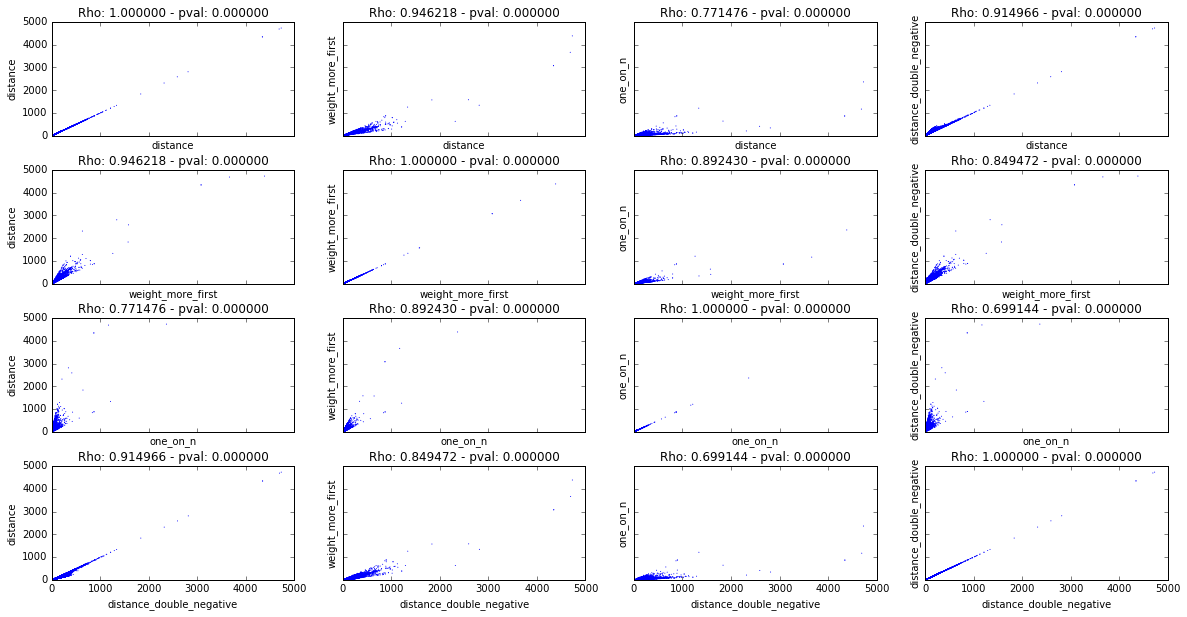

In [20]:
fig, ax =  plt.subplots(len(distances_fn), len(distances_fn), sharex='all', sharey='all')
plt.subplots_adjust(hspace = 0.3)

for i, first in enumerate(distances_fn):
    for j, second in enumerate(distances_fn):
        p = ax[i][j]
        p.scatter(distances[first.__name__], distances[second.__name__], s=1, edgecolors='none')
        rho, pval = scipy.stats.spearmanr(distances[first.__name__], distances[second.__name__])
        p.set_title("Rho: %f - pval: %f" % (rho, pval))
        p.axes.set_xlabel(first.__name__[6:])
        p.axes.set_ylabel(second.__name__[6:])
        plt.xlim(xmin=0)
        plt.ylim(ymin=0)

# Score d'un modèle
Pour choisir les hyper-paramètres qui caractérisent un modèle, il faut pouvoir le scorer pour pouvoir comparer deux modèles entre eux

In [21]:
def model_mean(errors):
    return np.mean(errors)

def score_k(k):
    knn = KNeighborsRegressor(n_neighbors=int(k), n_jobs=-1).fit(X_train, Y_train)
    predictions = knn.predict(X_test)
    
    diff = Y_test - predictions
    predictions_scores = np.apply_along_axis(score_distance, 1, diff)
    return model_mean(predictions_scores)


opts = {'maxiter': 20, 'disp': True, 'xatol': 0.1}
res = scipy.optimize.minimize_scalar(score_k, bounds=(1, 1000), method='bounded', options=opts)
print("Best k:", int(res.x))
print(res)

Best k: 223
     fun: 130.345926824012
 message: 'Solution found.'
    nfev: 17
  status: 0
 success: True
       x: 223.49275692968521


# Comparons avec du weighted kNN

In [22]:
def score_weighted_k(k):
    knn = KNeighborsRegressor(n_neighbors=int(k), n_jobs=-1, weights="distance").fit(X_train, Y_train)
    predictions = knn.predict(X_test)
    
    diff = Y_test - predictions
    predictions_scores = np.apply_along_axis(score_distance, 1, diff)
    return model_mean(predictions_scores)


opts = {'maxiter': 20, 'disp': True, 'xatol': 0.1}
res = scipy.optimize.minimize_scalar(score_weighted_k, bounds=(1, 500), method='bounded', options=opts)
print("Best k:", int(res.x))
print(res)

Best k: 213
     fun: 59.197346944484764
 message: 'Solution found.'
    nfev: 11
  status: 0
 success: True
       x: 213.5414479741253


# Comparons avec la STIB

In [23]:
knn = KNeighborsRegressor(n_neighbors=405, n_jobs=-1, weights="distance").fit(X_train, Y_train)
predictions = knn.predict(X_test)

In [24]:
stib_errors = []
knn_errors = []
a = []
for prediction, features, expected in zip(predictions, X_test, Y_test):
    indexes = np.where((X == features).all(axis=1))[0]
    if len(indexes) == 1:
        index = indexes[0]
        if index > 3 :#and not np.array_equal(expected,prediction):
            stib = np.mean(Y[index-3:index], axis=0)
            stib_errors.append(score_distance(expected - stib))
            knn_errors.append(score_distance(expected - prediction))

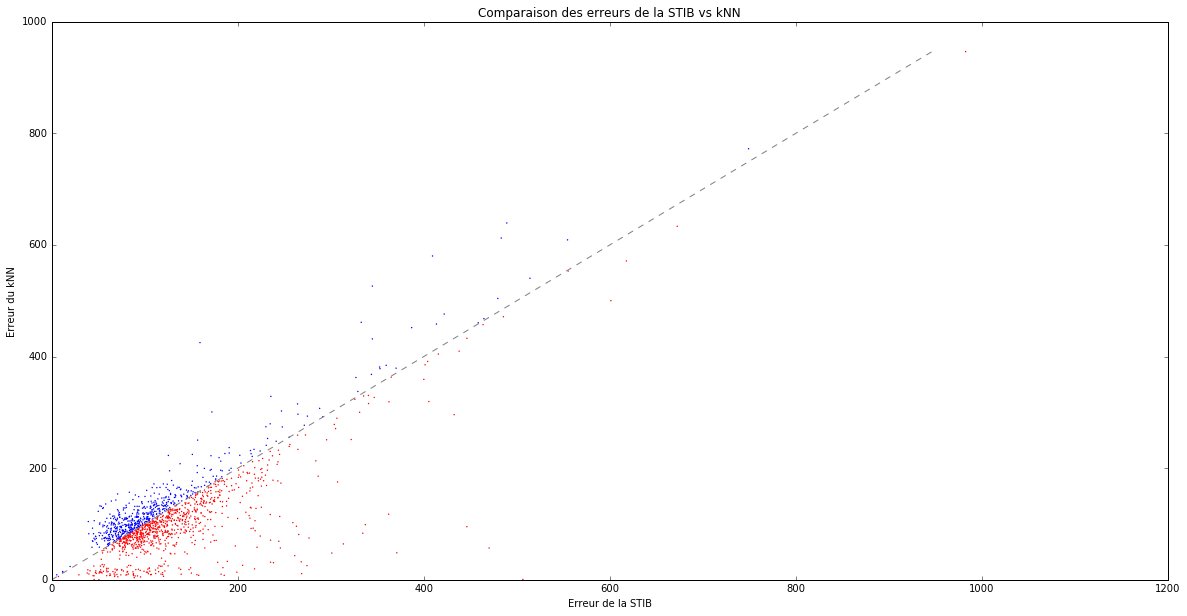

In [25]:
colors = ["red" if k < s else "blue" for s, k in zip(stib_errors, knn_errors)]
plt.scatter(stib_errors, knn_errors, s=2, c=colors, edgecolors='none')
m = min(max(stib_errors), max(knn_errors))
plt.plot([0, m], [0, m], linestyle="dashed", color="gray")
plt.title("Comparaison des erreurs de la STIB vs kNN")
plt.xlabel("Erreur de la STIB")
plt.ylabel("Erreur du kNN")
plt.xlim(xmin=0)
plt.ylim(ymin=0);

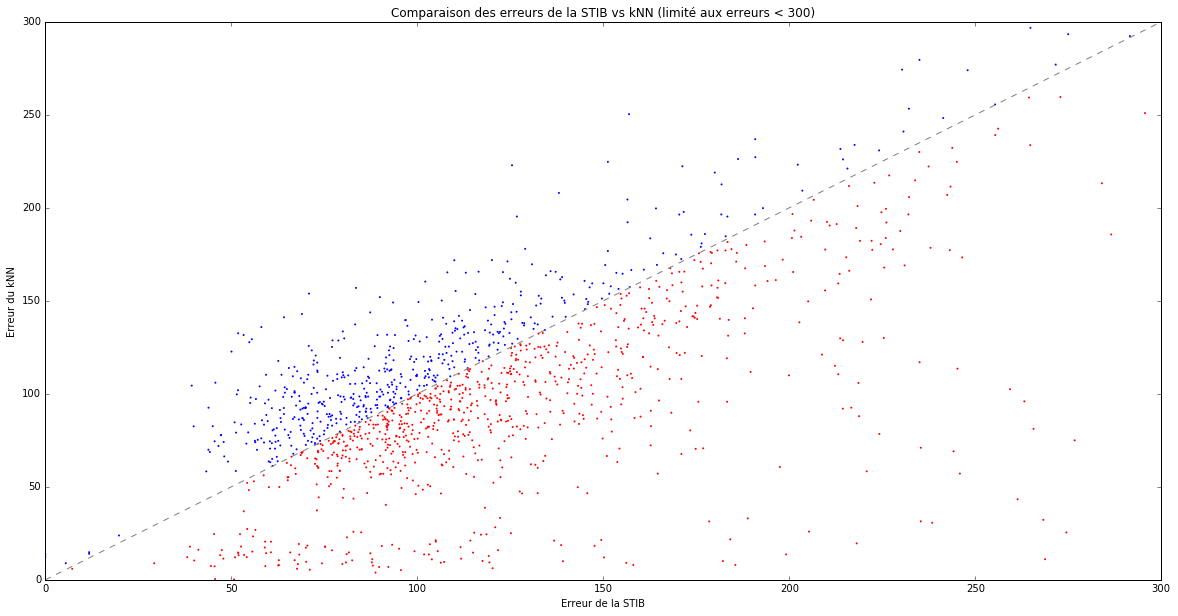

In [26]:
colors = ["red" if k < s else "blue" for s, k in zip(stib_errors, knn_errors)]
plt.scatter(stib_errors, knn_errors, s=4, c=colors, edgecolors='none')
m = min(max(stib_errors), max(knn_errors))
plt.plot([0, m], [0, m], linestyle="dashed", color="gray")
plt.title("Comparaison des erreurs de la STIB vs kNN (limité aux erreurs < 300)")
plt.xlabel("Erreur de la STIB")
plt.ylabel("Erreur du kNN")
plt.xlim(0,300)
plt.ylim(0,300);

In [27]:
knn_better = [k < s for s, k in zip(stib_errors, knn_errors)]

kkn_better_percent = len([x for x in knn_better if x]) / len(knn_better)
print("Knn est meilleur dans {:.2%}% des cas".format(kkn_better_percent))

Knn est meilleur dans 62.17%% des cas


In [28]:
knn1_better = [k * 1.5 < s for s, k in zip(stib_errors, knn_errors)]

kkn1_better_percent = len([x for x in knn1_better if x]) / len(knn1_better)
print("Knn est 1.5x meilleur dans {:.2%}% des cas".format(kkn1_better_percent))

Knn est 1.5x meilleur dans 18.31%% des cas


In [29]:
knn2_better = [k*2 < s for s, k in zip(stib_errors, knn_errors)]

kkn2_better_percent = len([x for x in knn2_better if x]) / len(knn2_better)
print("Knn est 2x meilleur dans {:.2%}% des cas".format(kkn2_better_percent))

Knn est 2x meilleur dans 11.32%% des cas


In [30]:
knn2_worst = [s*2 < k for s, k in zip(stib_errors, knn_errors)]

knn2_worst_percent = len([x for x in knn2_worst if x]) / len(knn2_worst)
print("Knn est 2x pire dans {:.2%}% des cas".format(knn2_worst_percent))

Knn est 2x pire dans 1.08%% des cas


In [31]:
knn1_worst = [s*1.5 < k for s, k in zip(stib_errors, knn_errors)]

knn1_worst_percent = len([x for x in knn1_worst if x]) / len(knn1_worst)
print("Knn est 1.5x pire dans {:.2%}% des cas".format(knn1_worst_percent))

Knn est 1.5x pire dans 5.69%% des cas
